# Household Power Consumption

Interesting one...
Would be good for a decent-sized test.  Several millions rows and lots of possible features.

## Example Raw Data

`Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000
16/12/2006;17:25:00;5.360;0.436;233.630;23.000;0.000;1.000;16.000`

## Data Format

1. Date - DD/MM/YYYY
2. Time - HH:MM:SS
3. Household Global Minute-Averaged Active Power - KW/min
4. Household Global Minute-Averaged Reactive Power - KW/min
5. Minute-Averaged Voltage - V/min
6. Household Global Minute-Averaged Current Intensity - A/min
7. Energy Sub-Metering No. 1 - W/hr (kitchen - dishwasher, oven, microwave (hot plates not electric))
8. Energy Sub-Metering No. 2 - W/hr (laundry room - washing-machine, tumble-drier, refrigerator, light)
9. Energy Sub-Metering No. 3 - W/hr (water-heater, air-conditioner)

** Some missing values, ~1.25%

## Observations

* #3 * 1000 / 60 => Household Global Active Power - W/hr
* (#3 * 1000 / 60) - #7 - #8 - #9 => Rest of Home - W/hr

## Other Stuff...

* Active Power
* Reactive Power
* True Power = Active Power + Reactive Power?
* Holidays, weekends..!
* Aggregations..!  E.g. provide last week's data at min intervals, then one month at hour intervals, then last year, etc.

* Daily patterns (people in morning, no one in day, people in evening, etc.)
* Weekly patterns (weekdays vs weekends)
* Seasonal patterns (spring, summer, etc.)
* Overlays (holidays - Thanksgiving, Christmas, etc.)
* Overlays (family vacations)

## Models...

* Regression on next minute's data...  This is sorta cute but how useful could it possibly be..?
* Regression on next hour..?  Maybe, this feels right-ish...  Maybe, every 3 hours because that would cover a period in the life of the inhabitant (e.g. getting up and getting ready, working, etc.)

## Get the Data, Mr Potata...

In [116]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt

import gcp.bigquery as bq

In [117]:
%%sql --module extraction

DEFINE QUERY raw_data
SELECT ts, global_active_power, global_reactive_power, voltage, intensity, sub_meter_1, sub_meter_2, sub_meter_3
FROM [bingo-ml-1:electricity.household_usage_ts]
ORDER BY ts ASC

In [118]:
raw_data_results = bq.Query(extraction.raw_data).results()
raw_data_results

ts,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.36,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
2006-12-16 17:29:00,3.52,0.522,235.02,15.0,0.0,2.0,17.0
2006-12-16 17:30:00,3.702,0.52,235.09,15.8,0.0,1.0,17.0
2006-12-16 17:31:00,3.7,0.52,235.22,15.8,0.0,1.0,17.0
2006-12-16 17:32:00,3.668,0.51,233.99,15.8,0.0,1.0,17.0
2006-12-16 17:33:00,3.662,0.51,233.86,15.8,0.0,2.0,16.0


In [119]:
raw_data = raw_data_results.to_dataframe(start_row=0, max_rows=500000)

In [120]:
raw_data[:10]

,ts,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0,1,17
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0,1,16
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0,2,17
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0,1,17
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0,1,17
5,2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0,2,17
6,2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0,1,17
7,2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0,1,17
8,2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0,1,17
9,2006-12-16 17:33:00,3.662,0.510,233.86,15.8,0,2,16


In [121]:
training_data = raw_data.set_index('ts')
training_data = training_data.resample('T', fill_method='ffill')
training_data[:10]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3
ts,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0,1,17
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0,1,16
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0,2,17
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0,1,17
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0,1,17
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0,2,17
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0,1,17
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0,1,17
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0,1,17


In [122]:
training_data.describe()

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3
count,503934.000000,503934.000000,503934.000000,503934.000000,503934.000000,503934.000000,503934.000000
mean,1.102239,0.119368,239.246652,4.709258,1.193035,1.628064,5.622516
std,1.154515,0.108522,3.520858,4.874406,6.358307,6.671764,8.112673
min,0.082000,0.000000,223.490000,0.400000,0.000000,0.000000,0.000000
25%,0.276000,0.000000,236.760000,1.200000,0.000000,0.000000,0.000000
50%,0.492000,0.102000,239.620000,2.200000,0.000000,0.000000,0.000000
75%,1.534000,0.190000,241.720000,6.400000,0.000000,1.000000,17.000000
max,10.670000,1.148000,251.700000,46.400000,78.000000,78.000000,20.000000


In [123]:
'''_ = training_data.plot(figsize=(20, 15))'''

'_ = training_data.plot(figsize=(20, 15))'

In [124]:
'''_ = training_data.global_active_power.plot(figsize=(20, 15))'''

'_ = training_data.global_active_power.plot(figsize=(20, 15))'

In [125]:
'''_ = training_data.global_reactive_power.plot(figsize=(20, 15))'''

'_ = training_data.global_reactive_power.plot(figsize=(20, 15))'

In [126]:
'''_ = training_data.voltage.plot(figsize=(20, 15))'''

'_ = training_data.voltage.plot(figsize=(20, 15))'

In [127]:
'''_ = training_data.intensity.plot(figsize=(20, 15))'''

'_ = training_data.intensity.plot(figsize=(20, 15))'

In [128]:
'''_ = training_data.sub_meter_1.plot(figsize=(20, 15))'''

'_ = training_data.sub_meter_1.plot(figsize=(20, 15))'

In [129]:
'''_ = training_data.sub_meter_2.plot(figsize=(20, 15))'''

'_ = training_data.sub_meter_2.plot(figsize=(20, 15))'

In [130]:
'''_ = training_data.sub_meter_3.plot(figsize=(20, 15))'''

'_ = training_data.sub_meter_3.plot(figsize=(20, 15))'

In [131]:
'''_ = training_data.sub_meter_1.plot(figsize=(20, 15), label='sub_meter_1')
_ = training_data.sub_meter_2.plot(figsize=(20, 15), label='sub_meter_2')
_ = training_data.sub_meter_3.plot(figsize=(20, 15), label='sub_meter_3')
_ = plt.legend(loc='upper right')'''

"_ = training_data.sub_meter_1.plot(figsize=(20, 15), label='sub_meter_1')\n_ = training_data.sub_meter_2.plot(figsize=(20, 15), label='sub_meter_2')\n_ = training_data.sub_meter_3.plot(figsize=(20, 15), label='sub_meter_3')\n_ = plt.legend(loc='upper right')"

In [132]:
'''training_data.corr()'''

'training_data.corr()'

In [133]:
'''_ = scatter_matrix(training_data, figsize=(20, 20), diagonal='kde')'''

"_ = scatter_matrix(training_data, figsize=(20, 20), diagonal='kde')"

In [134]:
training_data_processed = training_data.copy()

In [135]:
training_data_processed['global_active_power_w_hr'] = (training_data_processed.global_active_power * 1000) / 60
training_data_processed['global_reactive_power_w_hr'] = (training_data_processed.global_reactive_power * 1000) / 60
training_data_processed[:10]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,global_active_power_w_hr,global_reactive_power_w_hr
ts,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0,1,17,70.266667,6.966667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0,1,16,89.333333,7.266667
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0,2,17,89.566667,8.300000
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0,1,17,89.800000,8.366667
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0,1,17,61.100000,8.800000
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0,2,17,58.666667,8.700000
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0,1,17,61.700000,8.666667
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0,1,17,61.666667,8.666667
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0,1,17,61.133333,8.500000


In [136]:
training_data_processed['rest_of_home_pseudo_sub_meter'] = \
  training_data_processed.global_active_power_w_hr \
  - training_data_processed.sub_meter_1 \
  - training_data_processed.sub_meter_2 \
  - training_data_processed.sub_meter_3
training_data_processed[:10]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,global_active_power_w_hr,global_reactive_power_w_hr,rest_of_home_pseudo_sub_meter
ts,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0,1,17,70.266667,6.966667,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0,1,16,89.333333,7.266667,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0,2,17,89.566667,8.300000,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0,1,17,89.800000,8.366667,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0,1,17,61.100000,8.800000,43.100000
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0,2,17,58.666667,8.700000,39.666667
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0,1,17,61.700000,8.666667,43.700000
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0,1,17,61.666667,8.666667,43.666667
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0,1,17,61.133333,8.500000,43.133333


In [137]:
training_data_scaled = training_data_processed.copy()

from sklearn.preprocessing import MinMaxScaler

training_data_scaled = training_data_scaled.apply(lambda x: MinMaxScaler().fit_transform(x))
  
training_data_scaled = training_data_scaled.drop('global_active_power_w_hr', 1)
training_data_scaled = training_data_scaled.drop('global_reactive_power_w_hr', 1)
  
training_data_scaled.describe()

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,rest_of_home_pseudo_sub_meter
count,503934.000000,503934.000000,503934.000000,503934.000000,503934.000000,503934.000000,503934.000000,503934.000000
mean,0.096358,0.103979,0.558548,0.093680,0.015295,0.020873,0.281126,0.096885
std,0.109040,0.094531,0.124809,0.105965,0.081517,0.085535,0.405634,0.087019
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.018323,0.000000,0.470401,0.017391,0.000000,0.000000,0.000000,0.048205
50%,0.038723,0.088850,0.571783,0.039130,0.000000,0.000000,0.000000,0.060781
75%,0.137136,0.165505,0.646225,0.130435,0.000000,0.012821,0.850000,0.100865
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [138]:
'''plot = training_data_scaled.plot(figsize=(20, 15))
plot.set_ylim([0.0,1.2])
_ = plot.legend(loc='upper right')'''

"plot = training_data_scaled.plot(figsize=(20, 15))\nplot.set_ylim([0.0,1.2])\n_ = plot.legend(loc='upper right')"

In [139]:
'''fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(15)

_ = autocorrelation_plot(training_data_scaled.global_active_power, label='global_active_power')
_ = autocorrelation_plot(training_data_scaled.global_reactive_power, label='global_reactive_power')
_ = autocorrelation_plot(training_data_scaled.voltage, label='voltage')
_ = autocorrelation_plot(training_data_scaled.intensity, label='intensity')
_ = autocorrelation_plot(training_data_scaled.sub_meter_1, label='sub_meter_1')
_ = autocorrelation_plot(training_data_scaled.sub_meter_2, label='sub_meter_2')
_ = autocorrelation_plot(training_data_scaled.sub_meter_3, label='sub_meter_3')
_ = autocorrelation_plot(training_data_scaled.rest_of_home_pseudo_sub_meter, label='rest_of_home_pseudo_sub_meter')

_ = plt.legend(loc='upper right')'''

"fig = plt.figure()\nfig.set_figwidth(20)\nfig.set_figheight(15)\n\n_ = autocorrelation_plot(training_data_scaled.global_active_power, label='global_active_power')\n_ = autocorrelation_plot(training_data_scaled.global_reactive_power, label='global_reactive_power')\n_ = autocorrelation_plot(training_data_scaled.voltage, label='voltage')\n_ = autocorrelation_plot(training_data_scaled.intensity, label='intensity')\n_ = autocorrelation_plot(training_data_scaled.sub_meter_1, label='sub_meter_1')\n_ = autocorrelation_plot(training_data_scaled.sub_meter_2, label='sub_meter_2')\n_ = autocorrelation_plot(training_data_scaled.sub_meter_3, label='sub_meter_3')\n_ = autocorrelation_plot(training_data_scaled.rest_of_home_pseudo_sub_meter, label='rest_of_home_pseudo_sub_meter')\n\n_ = plt.legend(loc='upper right')"

In [140]:
training_data_scaled[:2]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,rest_of_home_pseudo_sub_meter
ts,,,,,,,,
2006-12-16 17:24:00,0.390442,0.364111,0.402340,0.391304,0,0.012821,0.85,0.429657
2006-12-16 17:25:00,0.498489,0.379791,0.359447,0.491304,0,0.012821,0.80,0.587372


In [141]:
training_data_scaled[-2:]

,global_active_power,global_reactive_power,voltage,intensity,sub_meter_1,sub_meter_2,sub_meter_3,rest_of_home_pseudo_sub_meter
ts,,,,,,,,
2007-12-01 16:16:00,0.126558,0.071429,0.742999,0.117391,0,0.012821,0.90,0.055803
2007-12-01 16:17:00,0.122592,0.000000,0.733782,0.113043,0,0.012821,0.95,0.042442


'import matplotlib\nplot.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())'

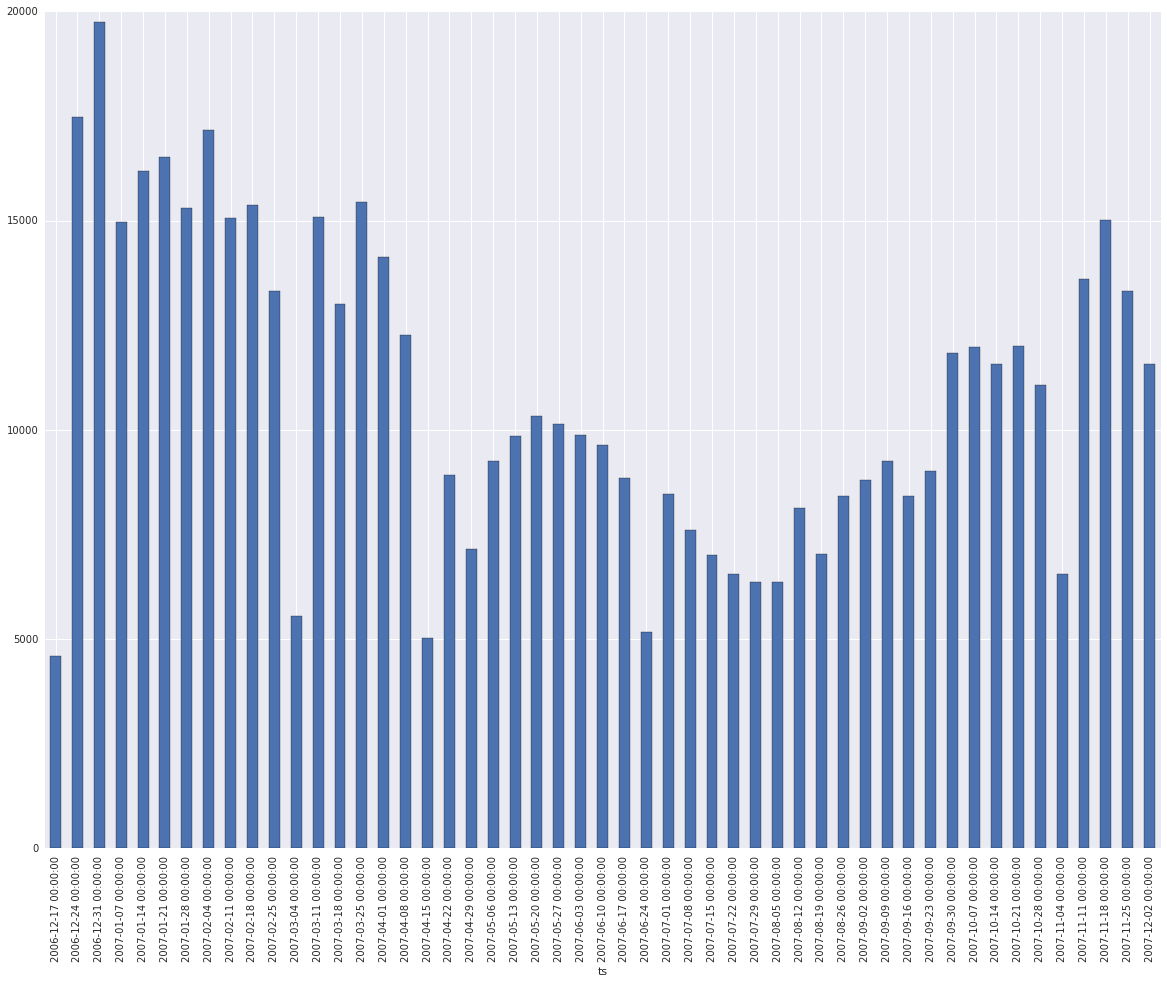

In [150]:
# Let's try some aggregations...

'''training_data_aggregated_5_min = training_data_processed.copy()
training_data_aggregated_5_min = training_data_aggregated.resample('5T', how='sum')

training_data_aggregated_15_min = training_data_processed.copy()
training_data_aggregated_15_min = training_data_aggregated.resample('15T', how='sum')

training_data_aggregated_1_hr = training_data_processed.copy()
training_data_aggregated_1_hr = training_data_aggregated_1_hr.resample('H', how='sum')'''

training_data_aggregated_1_day = training_data_processed.copy()
training_data_aggregated_1_day = training_data_aggregated_1_day.resample('W', how='sum')

plot = training_data_aggregated_1_day.global_active_power.plot(kind='bar')
plot.figure.set_figwidth(20)
_ = plot.figure.set_figheight(15)

'''import matplotlib
plot.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())'''

In [28]:
import tensorflow as tf

## Model I
* Use all features - global_active_power, global_reactive_power, voltage, intensity, sub_meter_1, sub_meter_2, sub_meter_3, rest_of_home_pseudo_sub_meter
* Use previous 30 trailing values to predict the next value

In [29]:
window = 120

training_data_tf_rows = []
for i in range(window+1, len(training_data_scaled)):
  ts = training_data_scaled.index[i]
  value = training_data_scaled.global_active_power[i]
  global_active_power_feature = training_data_scaled.global_active_power[i-1:i-1-window:-1]
  global_reactive_power_feature = training_data_scaled.global_reactive_power[i-1:i-1-window:-1]
  voltage_feature = training_data_scaled.voltage[i-1:i-1-window:-1]
  intensity_feature = training_data_scaled.intensity[i-1:i-1-window:-1]
  sub_meter_1_feature = training_data_scaled.sub_meter_1[i-1:i-1-window:-1]
  sub_meter_2_feature = training_data_scaled.sub_meter_2[i-1:i-1-window:-1]
  sub_meter_3_feature = training_data_scaled.sub_meter_3[i-1:i-1-window:-1]
  rest_of_home_pseudo_sub_meter_feature = training_data_scaled.rest_of_home_pseudo_sub_meter[i-1:i-1-window:-1]
    
  training_data_tf_row = np.concatenate([[ts], [value],
                                      global_active_power_feature.values,
                                      global_reactive_power_feature.values,
                                      voltage_feature.values,
                                      intensity_feature.values,
                                      sub_meter_1_feature.values,
                                      sub_meter_2_feature.values,
                                      sub_meter_3_feature.values,
                                      rest_of_home_pseudo_sub_meter_feature.values])
  training_data_tf_row_dict = dict(enumerate(training_data_tf_row))
  training_data_tf_rows.append(training_data_tf_row_dict)
  #training_data_tf_row_df = pd.DataFrame([training_data_tf_row])
  #training_data_tf = pd.concat([training_data_tf, training_data_tf_row_df])
  
  if (i%1000 == 0):
    print i
  
training_data_tf = pd.DataFrame(training_data_tf_rows)
training_data_tf = training_data_tf.set_index(0)
training_data_tf[:10]

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


,1,2,3,4,5,6,7,8,9,10,...,952,953,954,955,956,957,958,959,960,961
0,,,,,,,,,,,,,,,,,,,,,
2006-12-16 19:25:00,0.361533,0.337960,0.345891,0.343908,0.345671,0.355585,0.355144,0.355365,0.353822,0.352501,...,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621,0.561659,0.575929
2006-12-16 19:26:00,0.377396,0.361533,0.337960,0.345891,0.343908,0.345671,0.355585,0.355144,0.355365,0.353822,...,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621,0.561659
2006-12-16 19:27:00,0.376294,0.377396,0.361533,0.337960,0.345891,0.343908,0.345671,0.355585,0.355144,0.355365,...,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621
2006-12-16 19:28:00,0.380260,0.376294,0.377396,0.361533,0.337960,0.345891,0.343908,0.345671,0.355585,0.355144,...,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795
2006-12-16 19:29:00,0.376735,0.380260,0.376294,0.377396,0.361533,0.337960,0.345891,0.343908,0.345671,0.355585,...,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062
2006-12-16 19:30:00,0.354043,0.376735,0.380260,0.376294,0.377396,0.361533,0.337960,0.345891,0.343908,0.345671,...,0.309908,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642
2006-12-16 19:31:00,0.351840,0.354043,0.376735,0.380260,0.376294,0.377396,0.361533,0.337960,0.345891,0.343908,...,0.294561,0.309908,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373
2006-12-16 19:32:00,0.350077,0.351840,0.354043,0.376735,0.380260,0.376294,0.377396,0.361533,0.337960,0.345891,...,0.316101,0.294561,0.309908,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065
2006-12-16 19:33:00,0.349857,0.350077,0.351840,0.354043,0.376735,0.380260,0.376294,0.377396,0.361533,0.337960,...,0.285945,0.316101,0.294561,0.309908,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257


In [30]:
training_predictors_tf = training_data_tf[training_data_tf.columns[1:]]
training_classes_tf = training_data_tf[training_data_tf.columns[0]]

In [31]:
training_predictors_tf[:5]

,2,3,4,5,6,7,8,9,10,11,...,952,953,954,955,956,957,958,959,960,961
0,,,,,,,,,,,,,,,,,,,,,
2006-12-16 19:25:00,0.337960,0.345891,0.343908,0.345671,0.355585,0.355144,0.355365,0.353822,0.352501,0.352501,...,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621,0.561659,0.575929
2006-12-16 19:26:00,0.361533,0.337960,0.345891,0.343908,0.345671,0.355585,0.355144,0.355365,0.353822,0.352501,...,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621,0.561659
2006-12-16 19:27:00,0.377396,0.361533,0.337960,0.345891,0.343908,0.345671,0.355585,0.355144,0.355365,0.353822,...,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795,0.571621
2006-12-16 19:28:00,0.376294,0.377396,0.361533,0.337960,0.345891,0.343908,0.345671,0.355585,0.355144,0.355365,...,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062,0.339795
2006-12-16 19:29:00,0.380260,0.376294,0.377396,0.361533,0.337960,0.345891,0.343908,0.345671,0.355585,0.355144,...,0.392030,0.547388,0.557620,0.574852,0.445073,0.339257,0.340065,0.344373,0.344642,0.312062


In [32]:
training_classes_tf[:5]

0
2006-12-16 19:25:00    0.361533
2006-12-16 19:26:00    0.377396
2006-12-16 19:27:00    0.376294
2006-12-16 19:28:00    0.380260
2006-12-16 19:29:00    0.376735
Name: 1, dtype: float64

In [33]:
'''sessb = tf.Session()

feature_datab = tf.placeholder("float", [None, 2400])
actual_classesb = tf.placeholder("float", [None, 1])

weightsb = tf.Variable(tf.truncated_normal([2400, 1], stddev=0.0001))
biasesb = tf.Variable(tf.ones([1]))

modelb = tf.matmul(feature_datab, weightsb) + biasesb

costb = tf.sqrt(tf.reduce_mean(tf.square(actual_classesb - modelb)))

training_stepb = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(costb)

initb = tf.initialize_all_variables()
sessb.run(initb)'''

'sessb = tf.Session()\n\nfeature_datab = tf.placeholder("float", [None, 2400])\nactual_classesb = tf.placeholder("float", [None, 1])\n\nweightsb = tf.Variable(tf.truncated_normal([2400, 1], stddev=0.0001))\nbiasesb = tf.Variable(tf.ones([1]))\n\nmodelb = tf.matmul(feature_datab, weightsb) + biasesb\n\ncostb = tf.sqrt(tf.reduce_mean(tf.square(actual_classesb - modelb)))\n\ntraining_stepb = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(costb)\n\ninitb = tf.initialize_all_variables()\nsessb.run(initb)'

In [34]:
'''accuracyb = tf.sqrt(tf.reduce_mean(tf.square(actual_classesb - modelb)))

for i in range(1, 5001):
  sessb.run(
    training_stepb, 
    feed_dict={
      feature_datab: training_predictors_tf.values, 
      actual_classesb: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)
    }
  )
  if i%100 == 0:
    print i, sessb.run(
      accuracyb,
      feed_dict={
        feature_datab: training_predictors_tf.values, 
        actual_classesb: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)
      }
    )'''

'accuracyb = tf.sqrt(tf.reduce_mean(tf.square(actual_classesb - modelb)))\n\nfor i in range(1, 5001):\n  sessb.run(\n    training_stepb, \n    feed_dict={\n      feature_datab: training_predictors_tf.values, \n      actual_classesb: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)\n    }\n  )\n  if i%100 == 0:\n    print i, sessb.run(\n      accuracyb,\n      feed_dict={\n        feature_datab: training_predictors_tf.values, \n        actual_classesb: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)\n      }\n    )'

In [35]:
'''predictionsb = sessb.run(
    modelb, 
    feed_dict={
      feature_datab: training_predictors_tf.values, 
      actual_classesb: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)
    }
  )
predictionsb[:10]
tmpb = pd.DataFrame(training_classes_tf)
tmpb['xyz'] = predictionsb.ravel()
tmpb[:10]'''

"predictionsb = sessb.run(\n    modelb, \n    feed_dict={\n      feature_datab: training_predictors_tf.values, \n      actual_classesb: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)\n    }\n  )\npredictionsb[:10]\ntmpb = pd.DataFrame(training_classes_tf)\ntmpb['xyz'] = predictionsb.ravel()\ntmpb[:10]"

In [36]:
'''_ = tmpb.plot(figsize=(20, 15))'''

'_ = tmpb.plot(figsize=(20, 15))'

In [37]:
'''sessa = tf.Session()

feature_dataa = tf.placeholder("float", [None, 240])
actual_classesa = tf.placeholder("float", [None, 1])

weights1a = tf.Variable(tf.truncated_normal([240, 100], stddev=0.0001))
biases1a = tf.Variable(tf.ones([100]))

weights2a = tf.Variable(tf.truncated_normal([100, 1], stddev=0.0001))
biases2a = tf.Variable(tf.ones([1]))

hidden_layer_1a = tf.sigmoid(tf.matmul(feature_dataa, weights1a) + biases1a)
modela = tf.matmul(hidden_layer_1a, weights2a) + biases2a

costa = tf.sqrt(tf.reduce_mean(tf.square(actual_classesa - modela)))

training_stepa = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(costa)

inita = tf.initialize_all_variables()
sessa.run(inita)'''

'sessa = tf.Session()\n\nfeature_dataa = tf.placeholder("float", [None, 240])\nactual_classesa = tf.placeholder("float", [None, 1])\n\nweights1a = tf.Variable(tf.truncated_normal([240, 100], stddev=0.0001))\nbiases1a = tf.Variable(tf.ones([100]))\n\nweights2a = tf.Variable(tf.truncated_normal([100, 1], stddev=0.0001))\nbiases2a = tf.Variable(tf.ones([1]))\n\nhidden_layer_1a = tf.sigmoid(tf.matmul(feature_dataa, weights1a) + biases1a)\nmodela = tf.matmul(hidden_layer_1a, weights2a) + biases2a\n\ncosta = tf.sqrt(tf.reduce_mean(tf.square(actual_classesa - modela)))\n\ntraining_stepa = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(costa)\n\ninita = tf.initialize_all_variables()\nsessa.run(inita)'

In [38]:
'''accuracya = tf.sqrt(tf.reduce_mean(tf.square(actual_classesa - modela)))

for i in range(5000):
  
  start = 5000*(i%10)
  end = start+5000
  
  feature_data = training_predictors_tf[start:end].values
  actual_classes = training_classes_tf[start:end].values
  actual_classes_reshaped = actual_classes.reshape(len(actual_classes), 1)
  
  #print start, end, end-start, len(feature_data), len(actual_classes)
  
  sessa.run(
    training_stepa, 
    feed_dict={
      feature_dataa: feature_data, 
      actual_classesa: actual_classes_reshaped
    }
  )
  if i%50 == 0:
    print i, sessa.run(
      accuracya,
      feed_dict={
        feature_dataa: feature_data, 
        actual_classesa: actual_classes_reshaped
      }
    )'''

'accuracya = tf.sqrt(tf.reduce_mean(tf.square(actual_classesa - modela)))\n\nfor i in range(5000):\n  \n  start = 5000*(i%10)\n  end = start+5000\n  \n  feature_data = training_predictors_tf[start:end].values\n  actual_classes = training_classes_tf[start:end].values\n  actual_classes_reshaped = actual_classes.reshape(len(actual_classes), 1)\n  \n  #print start, end, end-start, len(feature_data), len(actual_classes)\n  \n  sessa.run(\n    training_stepa, \n    feed_dict={\n      feature_dataa: feature_data, \n      actual_classesa: actual_classes_reshaped\n    }\n  )\n  if i%50 == 0:\n    print i, sessa.run(\n      accuracya,\n      feed_dict={\n        feature_dataa: feature_data, \n        actual_classesa: actual_classes_reshaped\n      }\n    )'

In [39]:
'''predictionsa = sessa.run(
    modela, 
    feed_dict={
      feature_dataa: training_predictors_tf.values, 
      actual_classesa: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)
    }
  )
print predictionsa[:10]
tmpa = pd.DataFrame(training_classes_tf)
tmpa['xyz'] = predictionsa.ravel()
tmpa[:10]'''

"predictionsa = sessa.run(\n    modela, \n    feed_dict={\n      feature_dataa: training_predictors_tf.values, \n      actual_classesa: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)\n    }\n  )\nprint predictionsa[:10]\ntmpa = pd.DataFrame(training_classes_tf)\ntmpa['xyz'] = predictionsa.ravel()\ntmpa[:10]"

In [40]:
'''_ = tmpa[45000:45100].plot(style='-o', figsize=(20, 15))'''

"_ = tmpa[45000:45100].plot(style='-o', figsize=(20, 15))"

In [41]:
'''sessc = tf.Session()

feature_datac = tf.placeholder("float", [None, 2400])
actual_classesc = tf.placeholder("float", [None, 1])

weights1c = tf.Variable(tf.truncated_normal([2400, 100], stddev=0.0001))
biases1c = tf.Variable(tf.ones([100]))

weights2c = tf.Variable(tf.truncated_normal([100, 50], stddev=0.0001))
biases2c = tf.Variable(tf.ones([50]))

weights3c = tf.Variable(tf.truncated_normal([50, 1], stddev=0.0001))
biases3c = tf.Variable(tf.ones([1]))

hidden_layer_1c = tf.sigmoid(tf.matmul(feature_datac, weights1c) + biases1c)
hidden_layer_2c = tf.sigmoid(tf.matmul(hidden_layer_1c, weights2c) + biases2c)
modelc = tf.matmul(hidden_layer_2c, weights3c) + biases3c

costc = tf.sqrt(tf.reduce_mean(tf.square(actual_classesc - modelc)))

training_stepc = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(costc)

initc = tf.initialize_all_variables()
sessc.run(initc)'''

'sessc = tf.Session()\n\nfeature_datac = tf.placeholder("float", [None, 2400])\nactual_classesc = tf.placeholder("float", [None, 1])\n\nweights1c = tf.Variable(tf.truncated_normal([2400, 100], stddev=0.0001))\nbiases1c = tf.Variable(tf.ones([100]))\n\nweights2c = tf.Variable(tf.truncated_normal([100, 50], stddev=0.0001))\nbiases2c = tf.Variable(tf.ones([50]))\n\nweights3c = tf.Variable(tf.truncated_normal([50, 1], stddev=0.0001))\nbiases3c = tf.Variable(tf.ones([1]))\n\nhidden_layer_1c = tf.sigmoid(tf.matmul(feature_datac, weights1c) + biases1c)\nhidden_layer_2c = tf.sigmoid(tf.matmul(hidden_layer_1c, weights2c) + biases2c)\nmodelc = tf.matmul(hidden_layer_2c, weights3c) + biases3c\n\ncostc = tf.sqrt(tf.reduce_mean(tf.square(actual_classesc - modelc)))\n\ntraining_stepc = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(costc)\n\ninitc = tf.initialize_all_variables()\nsessc.run(initc)'

In [42]:
'''accuracyc = tf.sqrt(tf.reduce_mean(tf.square(actual_classesc - modelc)))

for i in range(1, 5001):
  sessc.run(
    training_stepc, 
    feed_dict={
      feature_datac: training_predictors_tf.values, 
      actual_classesc: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)
    }
  )
  if i%100 == 0:
    print i, sessc.run(
      accuracyc,
      feed_dict={
        feature_datac: training_predictors_tf.values, 
        actual_classesc: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)
      }
    )'''

'accuracyc = tf.sqrt(tf.reduce_mean(tf.square(actual_classesc - modelc)))\n\nfor i in range(1, 5001):\n  sessc.run(\n    training_stepc, \n    feed_dict={\n      feature_datac: training_predictors_tf.values, \n      actual_classesc: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)\n    }\n  )\n  if i%100 == 0:\n    print i, sessc.run(\n      accuracyc,\n      feed_dict={\n        feature_datac: training_predictors_tf.values, \n        actual_classesc: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)\n      }\n    )'

In [43]:
'''predictionsc = sessc.run(
    modelc, 
    feed_dict={
      feature_datac: training_predictors_tf.values, 
      actual_classesc: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)
    }
  )
print predictionsc[:10]
tmpc = pd.DataFrame(training_classes_tf)
tmpc['xyz'] = predictionsc.ravel()
tmpc[:10]'''

"predictionsc = sessc.run(\n    modelc, \n    feed_dict={\n      feature_datac: training_predictors_tf.values, \n      actual_classesc: training_classes_tf.values.reshape(len(training_classes_tf.values), 1)\n    }\n  )\nprint predictionsc[:10]\ntmpc = pd.DataFrame(training_classes_tf)\ntmpc['xyz'] = predictionsc.ravel()\ntmpc[:10]"

In [44]:
'''_ = tmpc.plot(figsize=(20, 15))'''

'_ = tmpc.plot(figsize=(20, 15))'

In [45]:
training_classes_tf.values
#training_predictors_tf.values

array([ 0.36153338,  0.3773959 ,  0.37629434, ...,  0.38048028,
        0.36968495,  0.19145186])

In [47]:
!pip install git+git://github.com/google/skflow.git

Downloading/unpacking git+git://github.com/google/skflow.git
  Cloning git://github.com/google/skflow.git to /tmp/pip-G1Fmwd-build
  Running setup.py (path:/tmp/pip-G1Fmwd-build/setup.py) egg_info for package from git+git://github.com/google/skflow.git
    
Downloading/unpacking sklearn (from skflow==0.0.1)
  Running setup.py (path:/tmp/pip-build-ws0WIN/sklearn/setup.py) egg_info for package sklearn
    
    file wheel-platform-tag-is-broken-on-empty-wheels-see-issue-141.py (for module wheel-platform-tag-is-broken-on-empty-wheels-see-issue-141) not found
  Running setup.py install for sklearn
    file wheel-platform-tag-is-broken-on-empty-wheels-see-issue-141.py (for module wheel-platform-tag-is-broken-on-empty-wheels-see-issue-141) not found
    file wheel-platform-tag-is-broken-on-empty-wheels-see-issue-141.py (for module wheel-platform-tag-is-broken-on-empty-wheels-see-issue-141) not found
    
    
    file wheel-platform-tag-is-broken-on-empty-wheels-see-issue-141.py (for module w

In [48]:
import skflow
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

y, X = training_classes_tf.values, training_predictors_tf.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, y_test

(array([[ 0.04009694,  0.04097819,  0.04163913, ...,  0.04011847,
          0.04308024,  0.05008078],
        [ 0.13637365,  0.12976427,  0.12447676, ...,  0.07081314,
          0.06300485,  0.06704362],
        [ 0.2350738 ,  0.15311743,  0.02665785, ...,  0.32498654,
          0.31017771,  0.30748519],
        ..., 
        [ 0.17294558,  0.17514871,  0.17338621, ...,  0.03634895,
          0.03392569,  0.0366182 ],
        [ 0.13791584,  0.13945803,  0.14077991, ...,  0.02234787,
          0.03123317,  0.03500269],
        [ 0.01101564,  0.01101564,  0.01586252, ...,  0.03042542,
          0.03123317,  0.02423263]]),
 array([ 0.03304693,  0.19938312,  0.23485349, ...,  0.1749284 ,
         0.13571271,  0.01057502]))

In [65]:
regressor = skflow.TensorFlowDNNRegressor(
  hidden_units=[250, 250],
  steps=1000000, 
  learning_rate=0.01, 
  batch_size=1)
regressor.fit(X_train, y_train)
score = mean_squared_error(regressor.predict(X_test), y_test)
print('MSE: {0:f}'.format(score))

Step #1, avg. loss: 0.16900
Step #100001, avg. loss: 0.00288
Step #200001, avg. loss: 0.00201
Step #300001, avg. loss: 0.00179
Step #400001, avg. loss: 0.00168
Step #500001, avg. loss: 0.00157
Step #600001, avg. loss: 0.00150
Step #700001, avg. loss: 0.00142
Step #800001, avg. loss: 0.00131
Step #900001, avg. loss: 0.00129
MSE: 0.001532


In [66]:
tmpd = pd.DataFrame(y_test)
tmpd['xyz'] = regressor.predict(X_test)
print tmpd[:10].dtypes

'''xyz = regressor.predict(X_test)
print len(xyz)

print len(y_test)'''

0      float64
xyz    float32
dtype: object


'xyz = regressor.predict(X_test)\nprint len(xyz)\n\nprint len(y_test)'

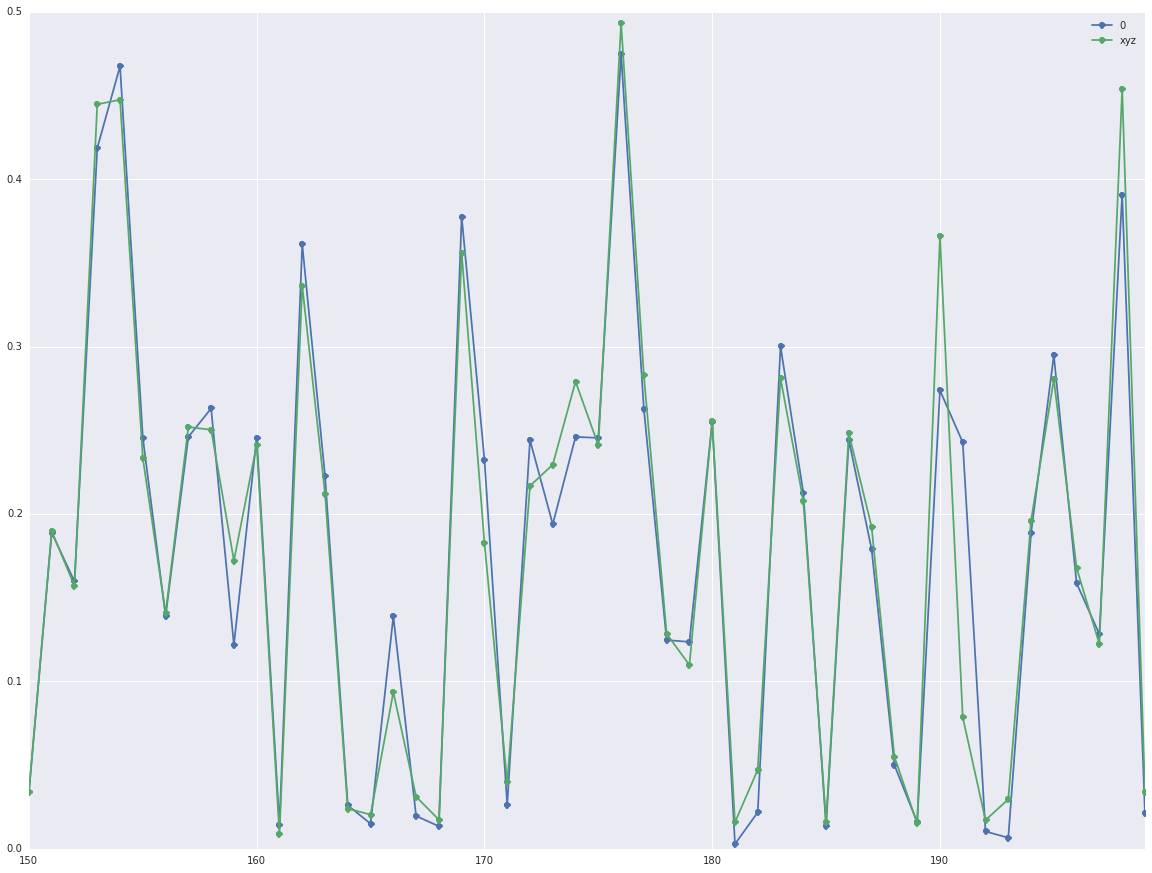

In [67]:
_ = tmpd[150:200].plot(style='-o', figsize=(20, 15))